# Exercise 3 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Dec 5, before 14:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 3`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (which is recommended) you have to mount the drive first and create a path to your python module (or download the file from your drive).

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [ ]:
# TODO import utils.py
from google.colab import files
files.upload()

In [ ]:
import Import_data 

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [ ]:
# TODO define device
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device


# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4
2 CPUs available


In [ ]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders
trainset, testset, dataset_mean, dataset_std = Import_data.grab_data(data_dir)

trainset, valset = Import_data.generate_train_val_data_split(trainset)

trainloader, valloader, testloader = Import_data.init_data_loaders(trainset, valset, testset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [ ]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

In [ ]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    stopping_pts = ()

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:          
          early_stopper.stopping_criterion(epoch_val_acc, model)
          
          if early_stopper.early_stop:
            print('Epoch :', str(epoch))   
            stopping_pts = (val_accs.index(max(val_accs))+1,max(val_accs))    
            break
            
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')

    if early_stopper:
      early_stopper.restore_best_checkpoint(model)

    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.scatter(extra_pt[0], extra_pt[1], color="red")
        ####################
        ## YOUR CODE HERE ##
        ####################
        #raise NotImplementedError # Comment out this keyword after your implementation

        # END OF YOUR CODE #
    legend = ['Train results', 'Validation results', extra_pt_label]   
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [ ]:
a = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
a.data.shape[0]

Files already downloaded and verified


50000

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

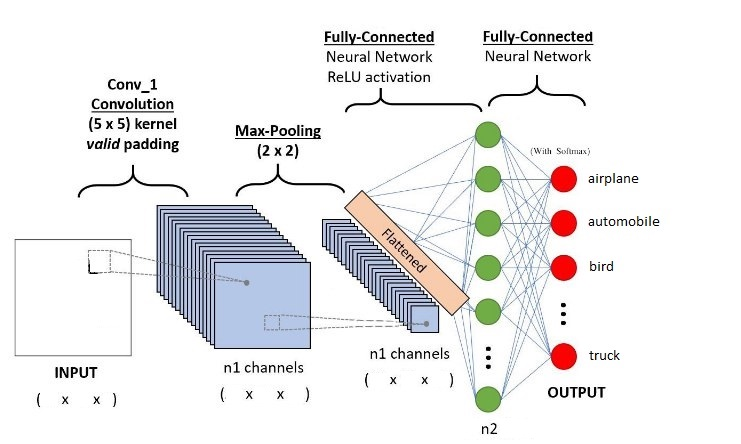

#### **Questions**

- What are the input dimensions? - [1024, 3, 32, 32]
- What are the dimensions of the feature maps? - 32 * 32 * 3 = 3072
- What are the dimensions after pooling? - 1024 in batch, 32 * 14 * 14 = 6272
- What is the value for n2 (in_features)? - 6272
- What is the number of parameters for conv_1? - 4

**Your answers here**
[1024, 3, 32, 32]; 32 * 32 * 3 = 3072; 1024 in batch, 32 * 14 * 14 = 6272; 6272; 4;


In [ ]:
# TODO define model
class NaturalSceneClassification(nn.Module):
    def __init__(self):
        super(NaturalSceneClassification, self).__init__()

        self.network = nn.Sequential(        
            nn.Conv2d(3, 32, kernel_size = 5, stride = 1),
            nn.MaxPool2d(kernel_size = (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(6272, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, xb):
      #print(xb.shape)
      return self.network(xb)

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 112 seconds.


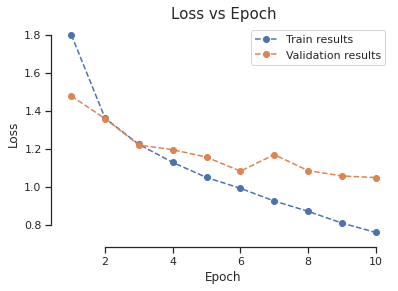

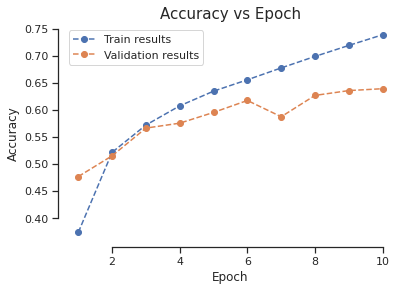

(9, 1.0474085867404939, 9, 0.6396)

In [ ]:
# TODO train and plot
model = NaturalSceneClassification()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, _ = \
  run_training(model, optimizer, loss_function, device, num_epochs, trainloader, valloader)

best_loss_epoch = np.argmin(val_losses)
best_loss = val_losses[best_loss_epoch]

best_acc_epoch = np.argmax(val_accs)
best_acc = val_accs[best_acc_epoch]

plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

best_loss_epoch, best_loss, best_acc_epoch, best_acc

#### **TODO**
Compare results to MLP. What can you observe? 

**Your answers here**
 What Acc of my model is better,and MLP is overfitted. same thing with the Loss 

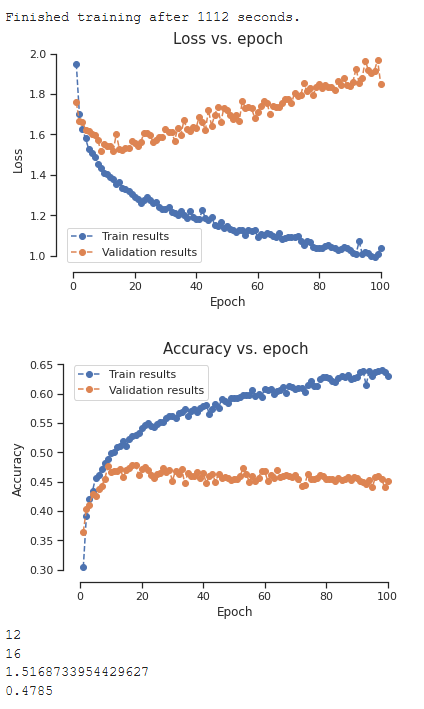

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 623 seconds.


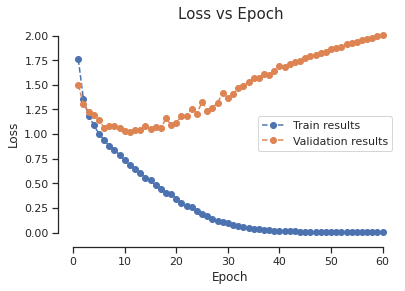

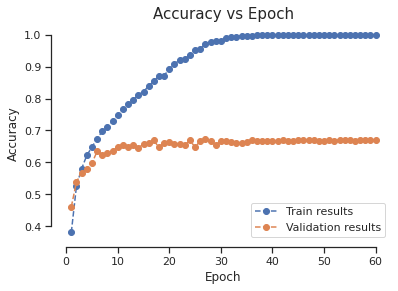

(10, 1.0192224442958833, 26, 0.6744)

In [ ]:
# TODO train and plot
model = NaturalSceneClassification()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 60
train_losses, val_losses, train_accs, val_accs, _ = \
  run_training(model, optimizer, loss_function, device, num_epochs, trainloader, valloader)

best_loss_epoch = np.argmin(val_losses)
best_loss = val_losses[best_loss_epoch]

best_acc_epoch = np.argmax(val_accs)
best_acc = val_accs[best_acc_epoch]

plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

best_loss_epoch, best_loss, best_acc_epoch, best_acc

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**
1) My model is overfitted

2)Add more layers and optimize hyperparameters, try another LR or something beside Adam


## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

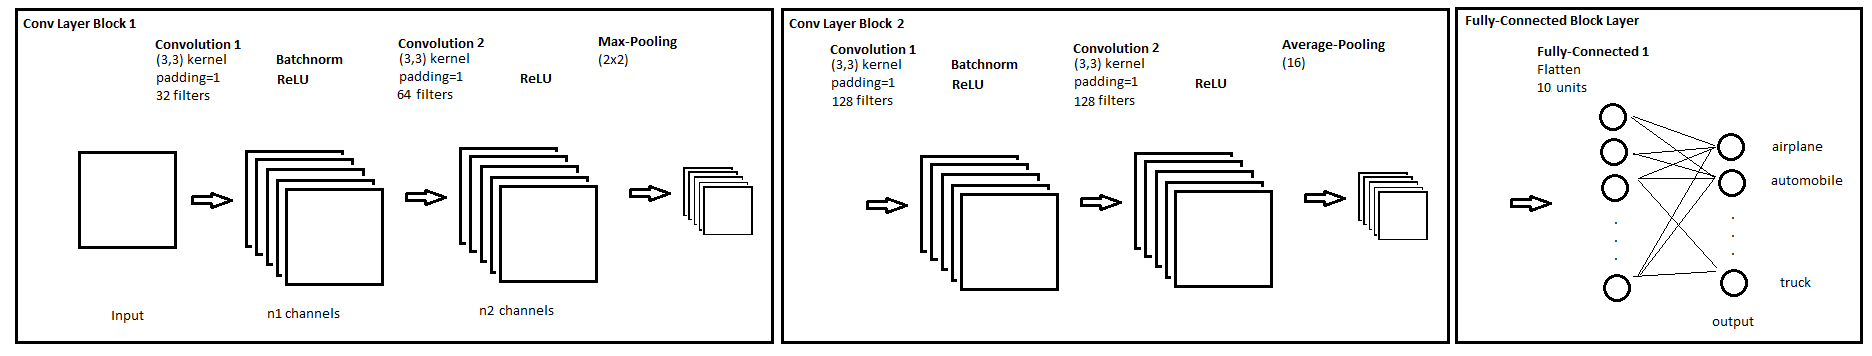

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?







1. Padding refers to the amount of pixels added to an image when it is being processed by the kernel of a CNN. max pooling and avg pooling. Padding adds zeros to the image to allow more space to be covered by the kernel.

2. padding = 1 means that there will be one pixel thick around the original image with pixel value = 0.


3. 16 * 16 * 64

4. 8 * 8 * 128

5. 2 (# of layers) + 1 >= input dimension ==> 2x+1 >= 32 => Receptive field = 8

6. 128

7. at n2: 64 * 3 * 3 * 32 => 18,432












**Your answers here**

In [ ]:
#TODO define model 2
class NaturalSceneClassification2(nn.Module):
    def __init__(self):
        super(NaturalSceneClassification2, self).__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.AvgPool2d(16),

            nn.Flatten(),
            nn.Linear(128,10)
        )
    
    def forward(self, xb):
      #print(xb.shape)
      return self.network(xb)

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results


The model trains much slower due to higher complexity, but can show better performance if trained longer

Finished training after 401 seconds.


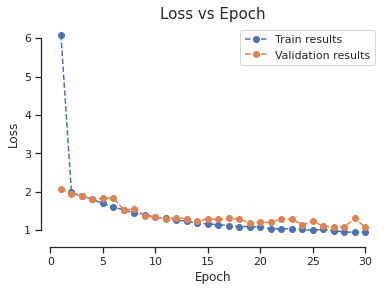

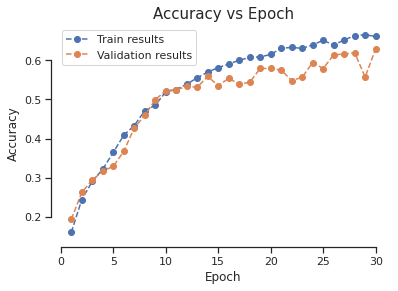

(29, 1.0712377071380614, 29, 0.629)

In [ ]:
# TODO train and plot
model = NaturalSceneClassification2()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

num_epochs = 30
train_losses, val_losses, train_accs, val_accs, _ = \
  run_training(model, optimizer, loss_function, device, num_epochs, trainloader, valloader)

best_loss_epoch = np.argmin(val_losses)
best_loss = val_losses[best_loss_epoch]

best_acc_epoch = np.argmax(val_accs)
best_acc = val_accs[best_acc_epoch]

plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

best_loss_epoch, best_loss, best_acc_epoch, best_acc

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

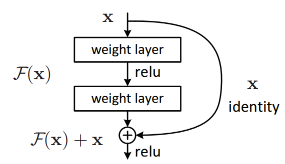

#### **Questions**
- Which problems do using skip connections solve?

- Why is a residual network called residual? 

- When is the advantage of ResNets over 'normal' CNNs most visible?


**Your answers here**

1) As a neural network gets deeper, the gradient from the loss function start to shrink to zero and thus the weights are not updated, this is known as the vanishing gradient problem. ResNet solves this by skipping connections. 

2) As we can see there is addition to the nornmal connection, there is a direct connection that skips layers in the model in the diagram above. Which is knows as skip connection or in another words - RESIDUAL connection. Here input is 'x', and we would like to learn the true distribution H(x). The residual between will be denoted as [ R(x) = Output - Input = H(x) - x ] which can be futher rearranged to [ H(x) = R(x) + x ]. The layers in a convention network learn from true output H(x), whereas layers in the residual network learn from residual R(x).

3) ResNets outperform normal CNN for a deeper networks problem. 

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

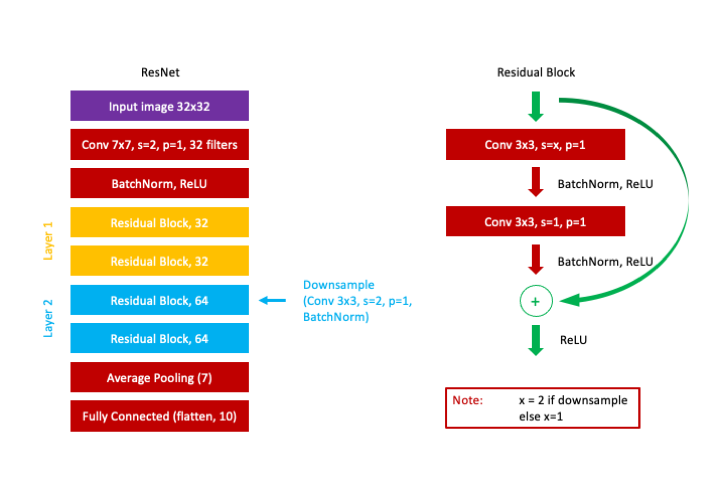

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [ ]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet 1
class ResidualBlock(nn.Module):
    def __init__(self, input_channel, intermediate_channels, downsample = None):
        super().__init__()
        self.downsample = downsample
        self.input_channel = input_channel
        if self.downsample is not None:
            self.stride = 2
            self.intermediate_channel = intermediate_channels * 2
            self.conv3 = nn.Conv2d(
                self.input_channel,
                self.intermediate_channel,
                kernel_size = 1,
                stride = self.stride,
                bias = False
            )
        else:
            self.stride = 1
            self.intermediate_channel = intermediate_channels

        self.conv1 = nn.Conv2d(input_channel, self.intermediate_channel, kernel_size = 3, stride = self.stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.intermediate_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            self.intermediate_channel,
            self.intermediate_channel,
            kernel_size = 3,
            stride = 1,
            padding = 1,
            bias = False
        )
        self.bn2 = nn.BatchNorm2d(self.intermediate_channel)

    def forward(self, x):
        indentity = x.clone()

        x = self.conv1(x)   
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            indentity = self.conv3(indentity)

        x += indentity
        x = self.relu(x)
        return x
        

In [ ]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
    def __init__(self, input_dimension, image_channels, num_classes):
        super().__init__()
        self.input_dimension = input_dimension
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer = nn.ModuleList([
            ResidualBlock(32, intermediate_channels=32).to(device),
            ResidualBlock(32, intermediate_channels=32, downsample=True).to(device),
            ResidualBlock(64, intermediate_channels=64).to(device),
            ResidualBlock(64, intermediate_channels=64).to(device)
        ])
        self.relu = nn.ReLU()
        self.averagepool = nn.AvgPool2d(7)
        self.fc = nn.Linear(64, num_classes) # linear layer 

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x) # batch normalization 
        x = self.relu(x)

        x = self.layer[0](x) # residual block |V
        x = self.layer[1](x)
        x = self.layer[2](x)
        x = self.layer[3](x)

        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1) # reshaped, 
        x = self.fc(x) #linear full connected ( linear-layer )
        return x 



In [ ]:
# TODO train ResNet, using the architecture laid out in the comments and figures above
model = ResNet(32, 3, 10)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs, _ = \
  run_training(model, optimizer, loss_function, device, num_epochs , trainloader, valloader)




Finished training after 671 seconds.


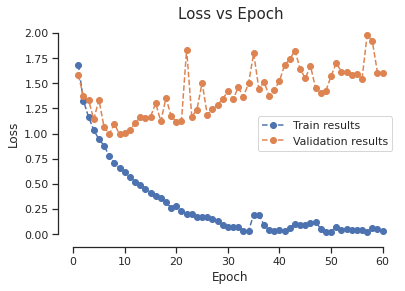

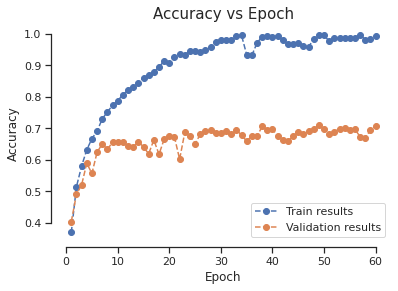

(8, 0.9911745071411133, 48, 0.7095)

In [ ]:
# TODO plot loss and accuracy for training and validation set
best_loss_epoch = np.argmin(val_losses)
best_loss = val_losses[best_loss_epoch]

best_acc_epoch = np.argmax(val_accs)
best_acc = val_accs[best_acc_epoch]

plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

best_loss_epoch, best_loss, best_acc_epoch, best_acc

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

1) Performance is little bit better

2) ResNet traines little bit longer

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

1)a) Learning rate is being decreased by 10 (or multiplied by 0.1) every epoch 
  b) Quite early learning rate becomes too small to train any further and overall performance stays quite low

2) a) Learning rate is being decreased by 1.1 (or multiplied by 0.9) every epoch
  b) This rate is much slower allowing to train efficiently for much longer. Performance is much higher

3) If model faces overfitting, one is required to either decrease step size or gamma. If model starts to train too slow, it makes sense to increase step size or gamma. Therefore step size and gamma have same effects, as decreasing gamma actually means increasing rapidness of learning rate changes.

In [ ]:
# Change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, scheduler=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        scheduler (StepLR, optional): If passed, model will be trainer with adaptive learning rate
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    stopping_pts = ()

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)
        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if scheduler:
          if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(np.mean(val_losses))
          else:
            scheduler.step()

        if early_stopper:          
          early_stopper.stopping_criterion(epoch_val_acc, model)
          
          if early_stopper.early_stop:
            print('Epoch :', str(epoch))   
            stopping_pts = (val_accs.index(max(val_accs))+1,max(val_accs))    
            break
            
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')

    if early_stopper:
      early_stopper.restore_best_checkpoint(model)

    return train_losses, val_losses, train_accs, val_accs, confusion_matrix



In [ ]:
def run_training_and_plot(model, optimizer, loss_function, device, num_epochs, 
                          trainloader, valloader, early_stopper=None, 
                          scheduler=None, verbose=False):
  train_losses, val_losses, train_accs, val_accs, _ = \
    run_training(model, optimizer, loss_function, device, 
                 num_epochs, trainloader, valloader, early_stopper, 
                 scheduler, verbose)

  best_loss_epoch = np.argmin(val_losses)
  best_loss = val_losses[best_loss_epoch]

  best_acc_epoch = np.argmax(val_accs)
  best_acc = val_accs[best_acc_epoch]

  plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
  plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

  print(best_loss_epoch, best_loss, best_acc_epoch, best_acc)


Finished training after 126 seconds.


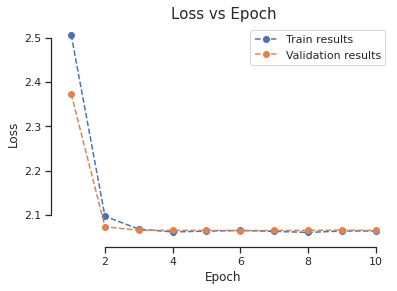

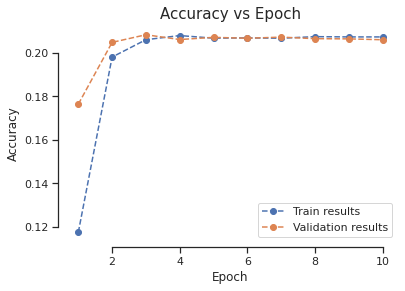

5 2.0646672010421754 2 0.2083


In [ ]:
# Train and plot with step size 1, gamma 0.1

model = ResNet(32, 3, 10)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

num_epochs = 10
run_training_and_plot(model, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler)


Adjusting learning rate of group 0 to 1.0000e-01.


Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e-02.
Adjusting learning rate of group 0 to 7.2900e-02.
Adjusting learning rate of group 0 to 6.5610e-02.
Adjusting learning rate of group 0 to 5.9049e-02.
Adjusting learning rate of group 0 to 5.3144e-02.
Adjusting learning rate of group 0 to 4.7830e-02.
Adjusting learning rate of group 0 to 4.3047e-02.
Adjusting learning rate of group 0 to 3.8742e-02.
Adjusting learning rate of group 0 to 3.4868e-02.
Finished training after 120 seconds.


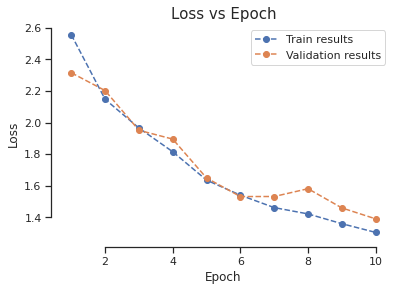

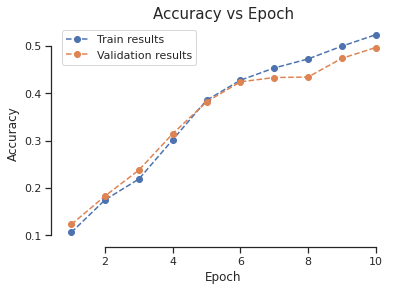

9 1.3901610255241394 9 0.4968


In [ ]:
# Train and plot with step size 1, gamma 0.9

model = ResNet(32, 3, 10)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9, verbose=True)

num_epochs = 10
run_training_and_plot(model, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler)


#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

1) Performance is little bit worser judging by accuracy, but loss stays good due to lack of noticable overfitting.

2) Plots look similar to the ones without scheduling except the part after chaning rate. On 13 and 14 epochs models still start to rapidly overfit. But changing learing rate stops overfitting giving both decent loss and accuracy in contrast to previous traning result, where best loss and accuracy epochs were at oposite ends of training charts

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cf87e6ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cf87e6ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Finished training after 381 seconds.


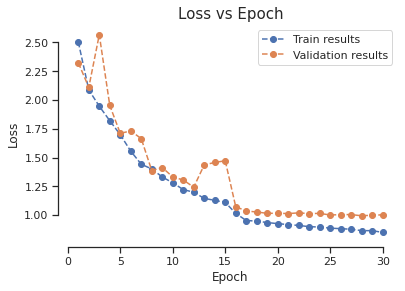

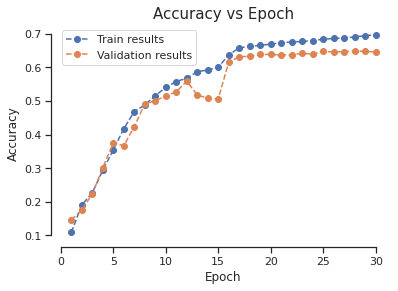

27 0.9940985798835754 27 0.6489


In [ ]:
# Train and plot with step size 15, gamma 0.1, 30 epochs.

model = ResNet(32, 3, 10)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

num_epochs = 30
run_training_and_plot(model, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler)

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

1) For ExponentialLR gamma 0.9 looks quite good. Training curves are quite gradual without much overfitting or perfomanse stagnations. ReduceLROnPlateau doesn't have much parameters, but 'max' works better, 'min' causes a lot of small flactuations during training.

2) Peak loss and accuracy values are lower, but final stats are better if we take into account both loss and accuracy.

3) Not much, but they are easier to tune as they have less parameters

Adjusting learning rate of group 0 to 1.0000e-01.


Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e-02.
Adjusting learning rate of group 0 to 7.2900e-02.
Adjusting learning rate of group 0 to 6.5610e-02.
Adjusting learning rate of group 0 to 5.9049e-02.
Adjusting learning rate of group 0 to 5.3144e-02.
Adjusting learning rate of group 0 to 4.7830e-02.
Adjusting learning rate of group 0 to 4.3047e-02.
Adjusting learning rate of group 0 to 3.8742e-02.
Adjusting learning rate of group 0 to 3.4868e-02.
Adjusting learning rate of group 0 to 3.1381e-02.
Adjusting learning rate of group 0 to 2.8243e-02.
Adjusting learning rate of group 0 to 2.5419e-02.
Adjusting learning rate of group 0 to 2.2877e-02.
Adjusting learning rate of group 0 to 2.0589e-02.
Adjusting learning rate of group 0 to 1.8530e-02.
Adjusting learning rate of group 0 to 1.6677e-02.
Adjusting learning rate of group 0 to 1.5009e-02.
Adjusting learning rate of group 0 to 1.3509e-02.
Adjusting learning rate of group 0 to 1.2158e-02.


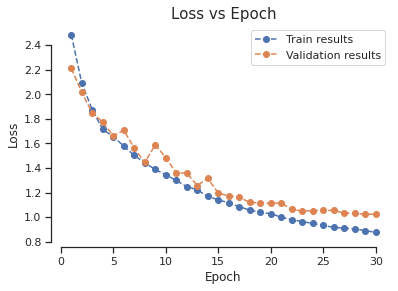

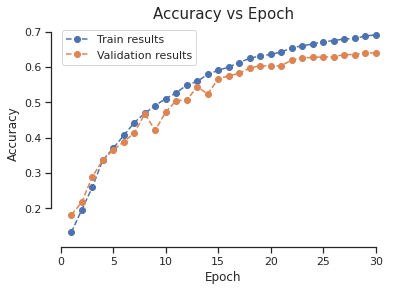

29 1.0230191588401794 28 0.6402


In [ ]:
# TODO train and plot

model = ResNet(32, 3, 10)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

num_epochs = 30
run_training_and_plot(model, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler)

Epoch 00012: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00023: reducing learning rate of group 0 to 1.0000e-03.


Finished training after 363 seconds.


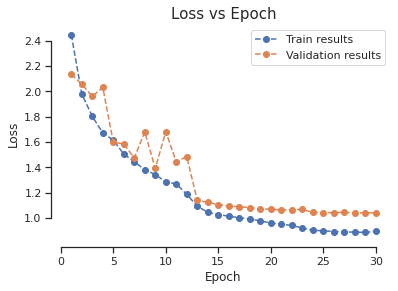

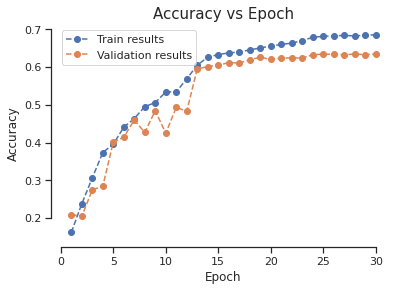

29 1.0394724190235138 27 0.6342


In [ ]:
model = ResNet(32, 3, 10)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', verbose=True)

num_epochs = 30
run_training_and_plot(model, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler)

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

1) No, performance with pre-trained weights is worse. Probably, because cifar10 dataset is big enough to train full model, so it would fit better then the one that trained on ImageNet

2) As we only train last layer, the model trains much faster. But hyperparameters tweeking doesn't improve performance much

Finished training after 367 seconds.


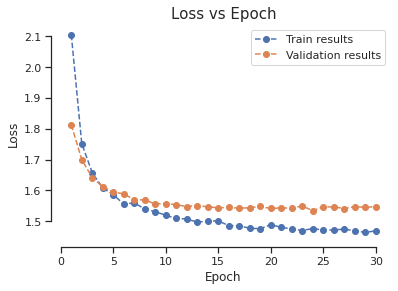

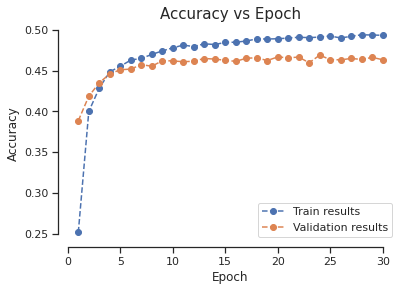

23 1.5344014048576355 23 0.4689


In [ ]:
# TODO do transfer learning with resnet on cifar10

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
		param.requires_grad = False

num_epochs = 30
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = None #StepLR(optimizer, step_size=20, gamma=0.5)

run_training_and_plot(model, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler, verbose=True)